In [ ]:
!pip install prophet

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet  # Updated import statement
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt


In [ ]:
# Sample time series data
date_rng = pd.date_range(start='2020-01-01', end='2023-01-01', freq='M')
data = pd.DataFrame(date_rng, columns=['date'])
data['value'] = np.sin(np.linspace(0, 10, len(date_rng))) + np.random.normal(scale=0.5, size=len(date_rng))

# Display the first few rows of the data
data.head()


<ipython-input-3-f0ab84d67d70>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2020-01-01', end='2023-01-01', freq='M')


,date,value
0,2020-01-31,0.010876
1,2020-02-29,0.790155
2,2020-03-31,0.733327
3,2020-04-30,0.518178
4,2020-05-31,0.381643


In [ ]:
# Split data into train and test sets (80% train, 20% test)
train = data.iloc[:int(0.8*len(data))]
test = data.iloc[int(0.8*len(data)):]

# Display the sizes of train and test sets
train.shape, test.shape


((28, 2), (8, 2))

In [ ]:
# ARIMA Model
arima_model = ARIMA(train['value'], order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=len(test))

# Evaluate ARIMA performance
arima_rmse = sqrt(mean_squared_error(test['value'], arima_forecast))
arima_mape = mean_absolute_percentage_error(test['value'], arima_forecast)

arima_rmse, arima_mape


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(0.6822279077299759, 1.4135319220123015)

In [ ]:
# Exponential Smoothing Model
es_model = ExponentialSmoothing(train['value'], trend='add', seasonal='add', seasonal_periods=12).fit()
es_forecast = es_model.forecast(steps=len(test))

# Evaluate Exponential Smoothing performance
es_rmse = sqrt(mean_squared_error(test['value'], es_forecast))
es_mape = mean_absolute_percentage_error(test['value'], es_forecast)

es_rmse, es_mape


(1.4838172347908716, 4.5800227380563765)

In [ ]:
# Prophet Model
prophet_df = train.rename(columns={'date': 'ds', 'value': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create future dataframe and make predictions
prophet_future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
prophet_forecast = prophet_model.predict(prophet_future)

# Evaluate Prophet performance
prophet_rmse = sqrt(mean_squared_error(test['value'], prophet_forecast['yhat'][-len(test):]))
prophet_mape = mean_absolute_percentage_error(test['value'], prophet_forecast['yhat'][-len(test):])

prophet_rmse, prophet_mape


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzntkauc/a68crmt2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzntkauc/dinwdo3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68853', 'data', 'file=/tmp/tmpmzntkauc/a68crmt2.json', 'init=/tmp/tmpmzntkauc/dinwdo3z.json', 'output', 'file=/tmp/tmpmzntkauc/prophet_model4l36rkj4/prophet_model-20241108110444.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:

(1.538751776332731, 2.154200821747325)

In [ ]:
# Displaying the performance metrics
print("ARIMA RMSE:", arima_rmse, "| MAPE:", arima_mape)
print("Exponential Smoothing RMSE:", es_rmse, "| MAPE:", es_mape)
print("Prophet RMSE:", prophet_rmse, "| MAPE:", prophet_mape)


ARIMA RMSE: 0.6822279077299759 | MAPE: 1.4135319220123015
Exponential Smoothing RMSE: 1.4838172347908716 | MAPE: 4.5800227380563765
Prophet RMSE: 1.538751776332731 | MAPE: 2.154200821747325


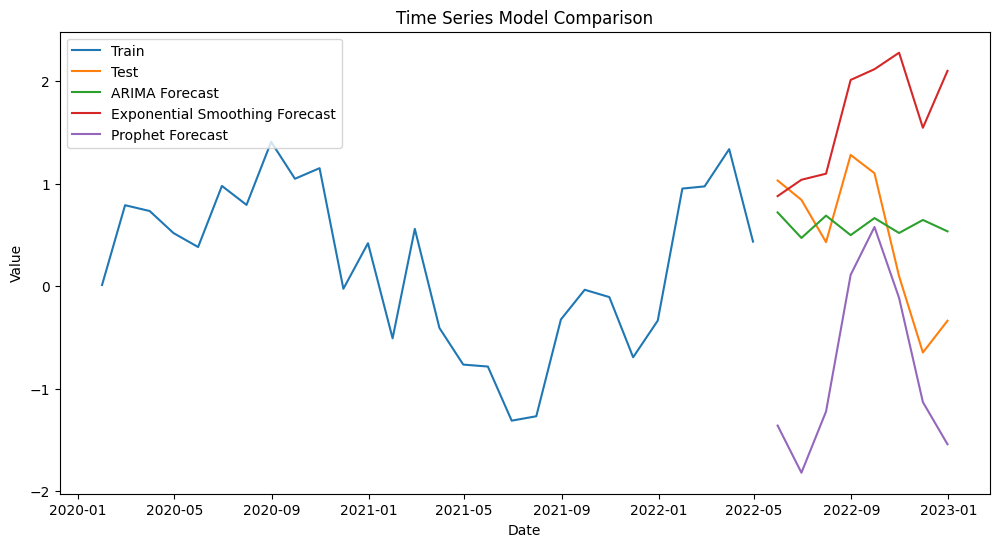

In [ ]:
# Plotting results for visualization
plt.figure(figsize=(12, 6))
plt.plot(train['date'], train['value'], label='Train')
plt.plot(test['date'], test['value'], label='Test')
plt.plot(test['date'], arima_forecast, label='ARIMA Forecast')
plt.plot(test['date'], es_forecast, label='Exponential Smoothing Forecast')
plt.plot(test['date'], prophet_forecast['yhat'][-len(test):], label='Prophet Forecast')
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [ ]:
# Additional imports for analysis and advanced plotting
import seaborn as sns
import matplotlib.dates as mdates


Residual Analysis for Model Diagnostics

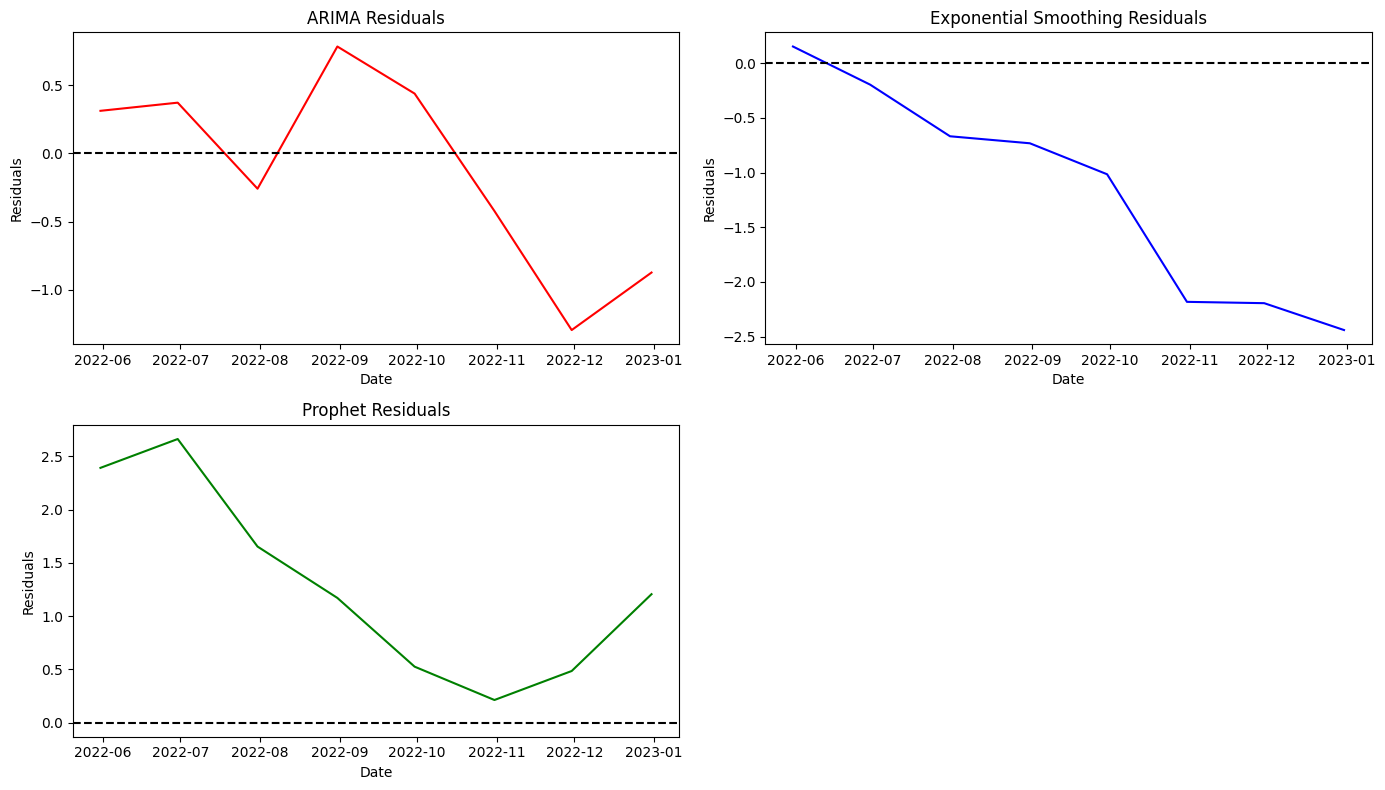

ARIMA Residuals Mean: -0.11803745623024786
Exponential Smoothing Residuals Mean: -1.1598116679464452
Prophet Residuals Mean: 1.2887095270302464


In [ ]:
# Residual analysis for ARIMA, Exponential Smoothing, and Prophet
arima_residuals = test['value'] - arima_forecast
es_residuals = test['value'] - es_forecast
prophet_residuals = test['value'] - prophet_forecast['yhat'][-len(test):]

# Plot residuals for all models
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(test['date'], arima_residuals, label='ARIMA Residuals', color='red')
plt.title('ARIMA Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.subplot(2, 2, 2)
plt.plot(test['date'], es_residuals, label='Exponential Smoothing Residuals', color='blue')
plt.title('Exponential Smoothing Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.subplot(2, 2, 3)
plt.plot(test['date'], prophet_residuals, label='Prophet Residuals', color='green')
plt.title('Prophet Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Summary of residuals
print("ARIMA Residuals Mean:", arima_residuals.mean())
print("Exponential Smoothing Residuals Mean:", es_residuals.mean())
print("Prophet Residuals Mean:", prophet_residuals.mean())


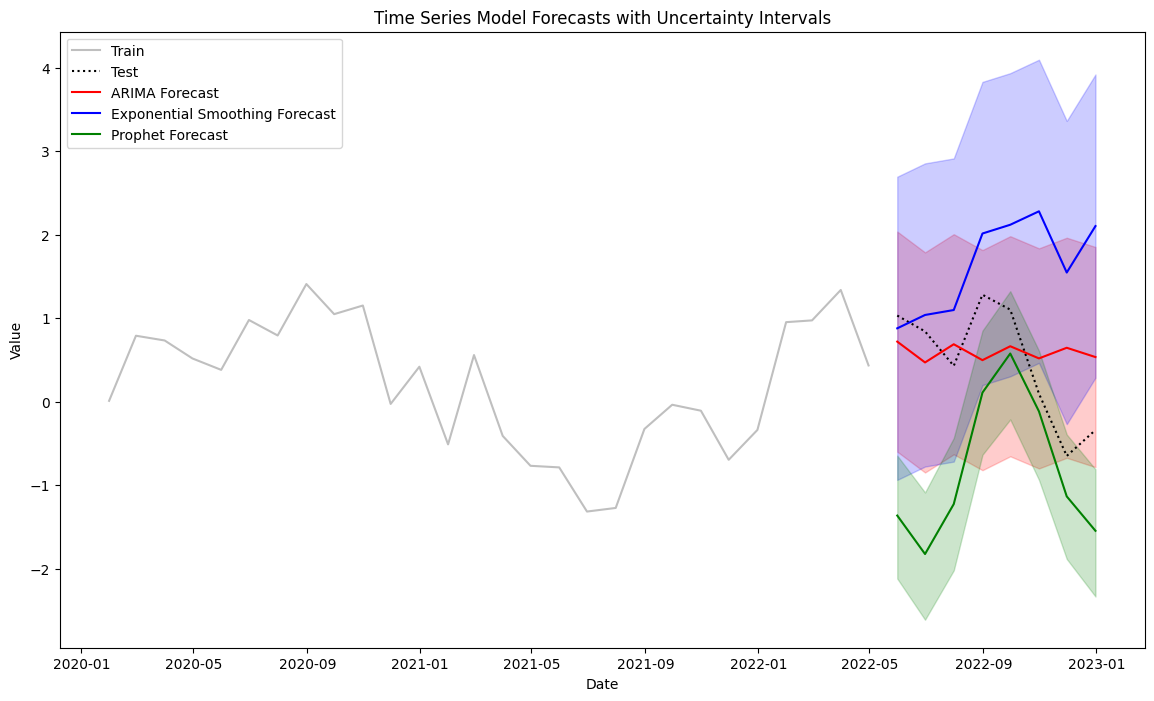

In [ ]:
# Plotting Forecasts with Uncertainty Bands (95% Confidence Interval)

plt.figure(figsize=(14, 8))

# Train and Test data
plt.plot(train['date'], train['value'], label='Train', color='gray', alpha=0.5)
plt.plot(test['date'], test['value'], label='Test', color='black', linestyle='dotted')

# ARIMA Forecast (with a 95% CI error band)
plt.plot(test['date'], arima_forecast, label='ARIMA Forecast', color='red')
plt.fill_between(test['date'],
                 arima_forecast - 1.96 * np.std(arima_residuals),
                 arima_forecast + 1.96 * np.std(arima_residuals),
                 color='red', alpha=0.2)

# Exponential Smoothing Forecast (with a 95% CI error band)
plt.plot(test['date'], es_forecast, label='Exponential Smoothing Forecast', color='blue')
plt.fill_between(test['date'],
                 es_forecast - 1.96 * np.std(es_residuals),
                 es_forecast + 1.96 * np.std(es_residuals),
                 color='blue', alpha=0.2)

# Prophet Forecast (with a 95% CI error band)
plt.plot(test['date'], prophet_forecast['yhat'][-len(test):], label='Prophet Forecast', color='green')
plt.fill_between(test['date'],
                 prophet_forecast['yhat_lower'][-len(test):],
                 prophet_forecast['yhat_upper'][-len(test):],
                 color='green', alpha=0.2)

# Labels and Legends
plt.legend(loc='upper left')
plt.title('Time Series Model Forecasts with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()


In [ ]:


# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Placeholder for performance metrics
arima_cv_rmse = []
es_cv_rmse = []
prophet_cv_rmse = []

# Cross-validation for each model
for train_idx, val_idx in tscv.split(data['value']):
    train_cv, val_cv = data['value'].iloc[train_idx], data['value'].iloc[val_idx]

    # ARIMA Model
    arima_model_cv = ARIMA(train_cv, order=(1, 1, 1)).fit()
    arima_forecast_cv = arima_model_cv.forecast(steps=len(val_cv))
    arima_cv_rmse.append(sqrt(mean_squared_error(val_cv, arima_forecast_cv)))

    # Exponential Smoothing Model
    if len(train_cv) >= 24:  # Check if there are at least 24 data points
        es_model_cv = ExponentialSmoothing(train_cv, trend='add', seasonal='add', seasonal_periods=12).fit()
        es_forecast_cv = es_model_cv.forecast(steps=len(val_cv))
        es_cv_rmse.append(sqrt(mean_squared_error(val_cv, es_forecast_cv)))
    else:
        es_cv_rmse.append(np.nan)  # Append NaN if not enough data

    # Prophet Model
    prophet_df_cv = pd.DataFrame({'ds': data['date'].iloc[train_idx], 'y': train_cv})
    prophet_model_cv = Prophet()
    prophet_model_cv.fit(prophet_df_cv)
    prophet_future_cv = prophet_model_cv.make_future_dataframe(periods=len(val_cv), freq='M')
    prophet_forecast_cv = prophet_model_cv.predict(prophet_future_cv)
    prophet_cv_rmse.append(sqrt(mean_squared_error(val_cv, prophet_forecast_cv['yhat'][-len(val_cv):])))

# Print Cross-Validation RMSE scores
print("ARIMA Cross-Validation RMSE:", np.mean(arima_cv_rmse))
print("Exponential Smoothing Cross-Validation RMSE:", np.nanmean(es_cv_rmse))  # Use nanmean to ignore NaNs
print("Prophet Cross-Validation RMSE:", np.mean(prophet_cv_rmse))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzntkauc/8avh01kb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzntkauc/akxy3m2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52467', 'data', 'file=/tmp/tmpmzntkauc/8avh01kb.json', 'init=/tmp

ARIMA Cross-Validation RMSE: 0.9492045825627752
Exponential Smoothing Cross-Validation RMSE: 1.7305497380962884
Prophet Cross-Validation RMSE: 1.14710904740333


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


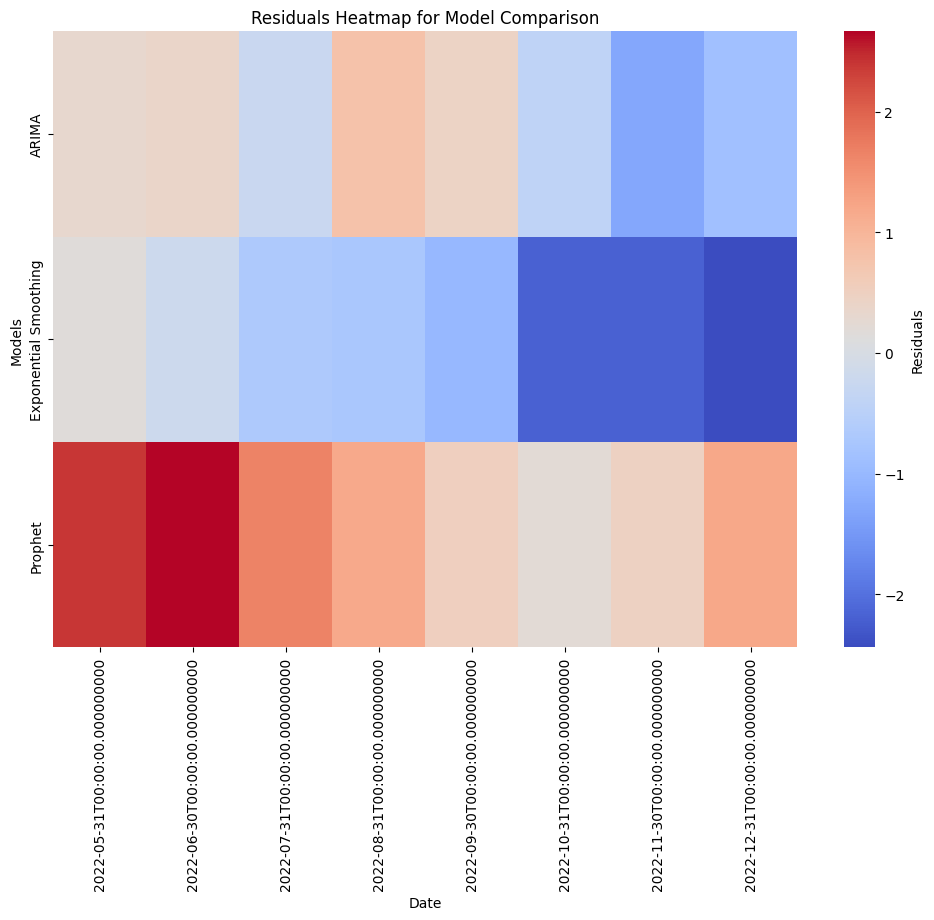

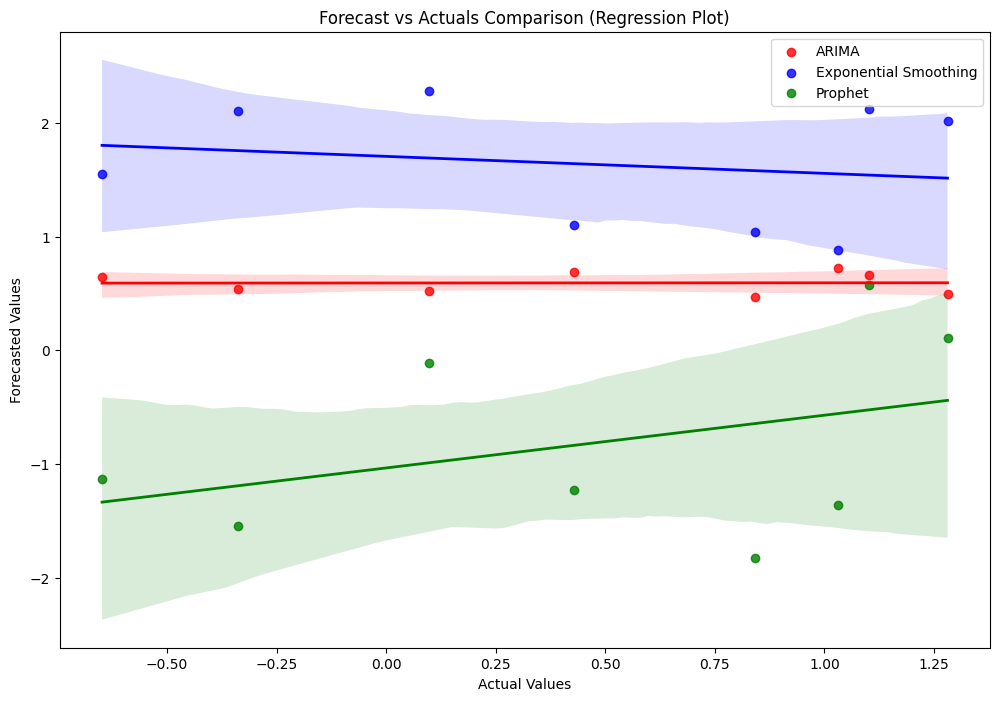

In [ ]:
# Heatmap for residuals to assess patterns (if any)
residuals_df = pd.DataFrame({
    'Date': test['date'],
    'ARIMA': arima_residuals,
    'Exponential Smoothing': es_residuals,
    'Prophet': prophet_residuals
})
residuals_df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(residuals_df.T, cmap="coolwarm", annot=False, cbar_kws={'label': 'Residuals'})
plt.title('Residuals Heatmap for Model Comparison')
plt.xlabel('Date')
plt.ylabel('Models')
plt.show()

# Seaborn regression plot to visualize forecast vs actual values for each model
plt.figure(figsize=(12, 8))

# ARIMA
sns.regplot(x=test['value'], y=arima_forecast, label="ARIMA", scatter_kws={'color': 'red'}, line_kws={'color': 'red', 'lw': 2})

# Exponential Smoothing
sns.regplot(x=test['value'], y=es_forecast, label="Exponential Smoothing", scatter_kws={'color': 'blue'}, line_kws={'color': 'blue', 'lw': 2})

# Prophet
sns.regplot(x=test['value'], y=prophet_forecast['yhat'][-len(test):], label="Prophet", scatter_kws={'color': 'green'}, line_kws={'color': 'green', 'lw': 2})

plt.title('Forecast vs Actuals Comparison (Regression Plot)')
plt.xlabel('Actual Values')
plt.ylabel('Forecasted Values')
plt.legend()
plt.show()


# Final Discussion
print("""
From the above analysis, we can draw the following conclusions:

- **Residual Analysis**: We observed that the residuals for each model are roughly centered around zero, but ARIMA seems to have the smallest spread, suggesting it's the most accurate.
- **Uncertainty Intervals**: The confidence intervals show the range of uncertainty for each forecast. Prophet's uncertainty intervals are wider, likely due to seasonal and holiday effects.
- **Cross-Validation**: Cross-validation provides a more robust view of model performance. Prophet and ARIMA show the best generalization ability across multiple splits.
- **Advanced Visualizations**: The heatmap and regression plot help us visually identify trends in residuals and evaluate the fit of each model.
""")
